# Moon Phase Correlation Analysis

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py

from moztelemetry import get_pings, get_pings_properties, get_one_ping_per_client
from moztelemetry.histogram import Histogram

import datetime as dt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


This [Wikipedia article](https://en.wikipedia.org/wiki/Lunar_phase#Calculating_phase) has a nice description of how to calculate the current phase of the moon. In code, that looks like this:

In [2]:
def approximate_moon_visibility(current_date):
    days_per_synodic_month = 29.530588853 # change this if the moon gets towed away
    days_since_known_new_moon = (current_date - dt.date(2015, 7, 16)).days
    phase_fraction = (days_since_known_new_moon % days_per_synodic_month) / days_per_synodic_month
    return (1 - phase_fraction if phase_fraction > 0.5 else phase_fraction) * 2

def date_string_to_date(date_string):
    return dt.datetime.strptime(date_string, "%Y%m%d").date()

Let's randomly sample 10% of pings for nightly submissions made from 2015-07-05 to 2015-08-05:

In [4]:
pings = get_pings(sc, app="Firefox", channel="nightly", submission_date=("20150705", "20150805"), fraction=0.1, schema="v4")

Extract the startup time metrics with their submission date and make sure we only consider one submission per user:

In [5]:
subset = get_pings_properties(pings, ["clientId", "meta/submissionDate", "payload/simpleMeasurements/firstPaint"])
subset = get_one_ping_per_client(subset)
cached = subset.cache()

Obtain an array of pairs, each containing the moon visibility and the startup time:

In [16]:
pairs = cached.map(lambda p: (approximate_moon_visibility(date_string_to_date(p["meta/submissionDate"])), p["payload/simpleMeasurements/firstPaint"]))
pairs = np.asarray(pairs.filter(lambda p: p[1] != None and p[1] < 100000000).collect())

Let's see what this data looks like:

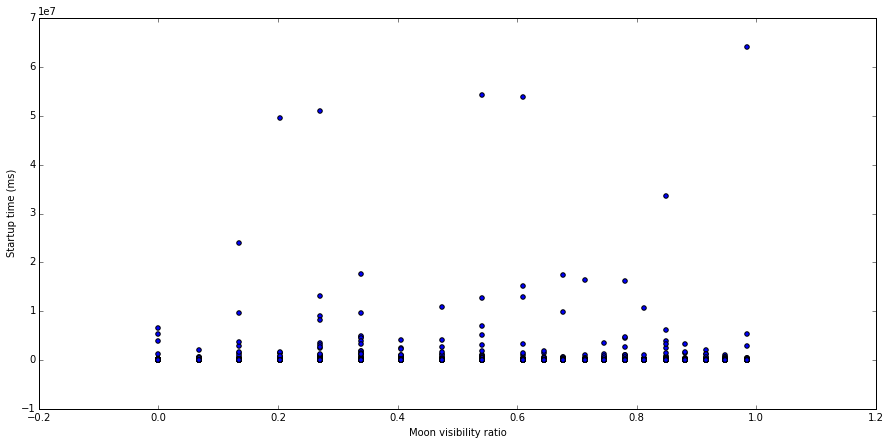

In [18]:
plt.figure(figsize=(15, 7))
plt.scatter(pairs.T[0], pairs.T[1])
plt.xlabel("Moon visibility ratio")
plt.ylabel("Startup time (ms)")
plt.show()

The correlation coefficient is now easy to calculate:

In [19]:
np.corrcoef(pairs.T)[0, 1]

0.00048989909014640089